In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os 
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Download file

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import data

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# Clean data and create extra features

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]

    # Create YEAR_WEEK column
    df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)

    # Create WIN_LOSS column
    df['WIN_LOSS'] = (df['DIVIDENDS_PAID'] >= df['TOTAL_TURNOVER']).astype('int32')
    
    return df

df = clean_data(df)

In [9]:
def cus_aggregate(df):
    cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False).agg({'AGE_BAND':min, 'GENDER': min, 'RESIDENTIAL_STATE':min})
    return cus_df

cus_df = cus_aggregate(df)

,BET_ACCOUNT_NUM_HASH,AGE_BAND,GENDER,RESIDENTIAL_STATE
0,13154,65+,M,WA
1,18379,45-54,M,WA
2,37251,18-24,U,WA
3,129273,18-24,U,WA
4,348318,25-34,U,WA
...,...,...,...,...
144824,4294834703,45-54,M,WA
144825,4294891076,65+,F,WA
144826,4294928673,35-44,U,WA
144827,4294964456,18-24,U,WA


# Aggregate

In [52]:
def weekly_aggregate(df,year_week=202122, weeks=4):
    # Aggregate
    agg_df = df[(df['YEAR_WEEK'] > year_week-weeks ) & (df['YEAR_WEEK'] <= year_week)].groupby('BET_ACCOUNT_NUM_HASH').agg({
        'BET_ACCOUNT_NUM_HASH': np.size,
        'TENURE_IN_DAYS' : max,
        'RACING_TURNOVER': sum,
        'TOTAL_TURNOVER' : sum,
        'DIVIDENDS_PAID' : sum,
        'TICKETS' : sum
    })
    
    # Create ratio columns
    agg_df['RACING_TURNOVER'] = agg_df['RACING_TURNOVER'] / agg_df['TOTAL_TURNOVER']
    agg_df['DIVIDENDS_PAID'] = agg_df['DIVIDENDS_PAID'] / agg_df['TOTAL_TURNOVER']

    # Create average columns
    agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] = agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] / (weeks*7)
    
    agg_df.columns = ['AVG_FREQ_' + str(weeks), 
                     'TENURE_IN_DAYS_' + str(weeks), 
                     'RACING_RATIO_' + str(weeks),
                     'AVG_TURNOVER_' + str(weeks),
                     'DIVIDENDS_RATIO_' + str(weeks),
                     'AVG_TICKETS_' + str(weeks)]
    
    return agg_df

In [53]:
def total_aggregate(df,year_week):
    # Prediction (4 weeks after the current week)
    pred = df[ (df['YEAR_WEEK'] > year_week ) & (df['YEAR_WEEK'] <= year_week + 4)].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum() / 28
    
    # 12 weeks bef0re
    train_12 = weekly_aggregate(df,year_week=202122, weeks=12)
    train_4 = weekly_aggregate(df,year_week=202122, weeks=4)
    train_1 = weekly_aggregate(df,year_week=202122, weeks=1)
    
    # Filter new customers
    train_12 = train_12[train_12['TENURE_IN_DAYS_12'] >= 84]
    
    # Join data
    train = pd.merge(train_12, train_4, left_index=True, right_index=True, how='left')
    train = pd.merge(train, train_1, left_index=True, right_index=True, how='left')
    train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

    # Fill na
    train.fillna(0, inplace=True)
    
    return train

In [54]:
year_week=202122

train = total_aggregate(df, year_week)

In [55]:
train

,AVG_FREQ_12,TENURE_IN_DAYS_12,RACING_RATIO_12,AVG_TURNOVER_12,DIVIDENDS_RATIO_12,AVG_TICKETS_12,AVG_FREQ_4,TENURE_IN_DAYS_4,RACING_RATIO_4,AVG_TURNOVER_4,DIVIDENDS_RATIO_4,AVG_TICKETS_4,AVG_FREQ_1,TENURE_IN_DAYS_1,RACING_RATIO_1,AVG_TURNOVER_1,DIVIDENDS_RATIO_1,AVG_TICKETS_1,TOTAL_TURNOVER
BET_ACCOUNT_NUM_HASH,,,,,,,,,,,,,,,,,,,
13154,0.71,12002,1.00,829.55,0.76,243.00,0.71,12002.00,1.00,913.25,0.74,265.21,1.00,12002.00,1.00,1471.27,0.69,436.14,662.00
18379,0.19,2039,1.00,28.08,0.82,0.86,0.21,2039.00,1.00,28.71,0.47,1.11,0.29,2039.00,1.00,7.14,1.74,0.29,21.50
385032,0.02,2364,1.00,0.23,0.00,0.05,0.04,2364.00,1.00,0.57,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.61
433164,0.37,531,1.00,55.13,0.86,99.82,0.25,531.00,1.00,26.38,0.71,31.11,0.14,531.00,1.00,8.00,0.29,17.00,9.38
537985,0.02,3121,0.87,1.36,0.83,0.29,0.07,3121.00,0.87,4.07,0.83,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4294561160,0.11,2986,1.00,2.86,0.00,0.33,0.04,2986.00,1.00,2.50,0.00,0.14,0.14,2986.00,1.00,10.00,0.00,0.57,0.00
4294699441,0.01,6996,1.00,0.31,0.81,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4294707367,0.01,2028,1.00,0.12,2.22,0.02,0.04,2028.00,1.00,0.36,2.22,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.71


# Linear Regression

In [56]:
train_1 = train.drop(['TENURE_IN_DAYS_1', 'TENURE_IN_DAYS_4','TENURE_IN_DAYS_12'],axis=1)

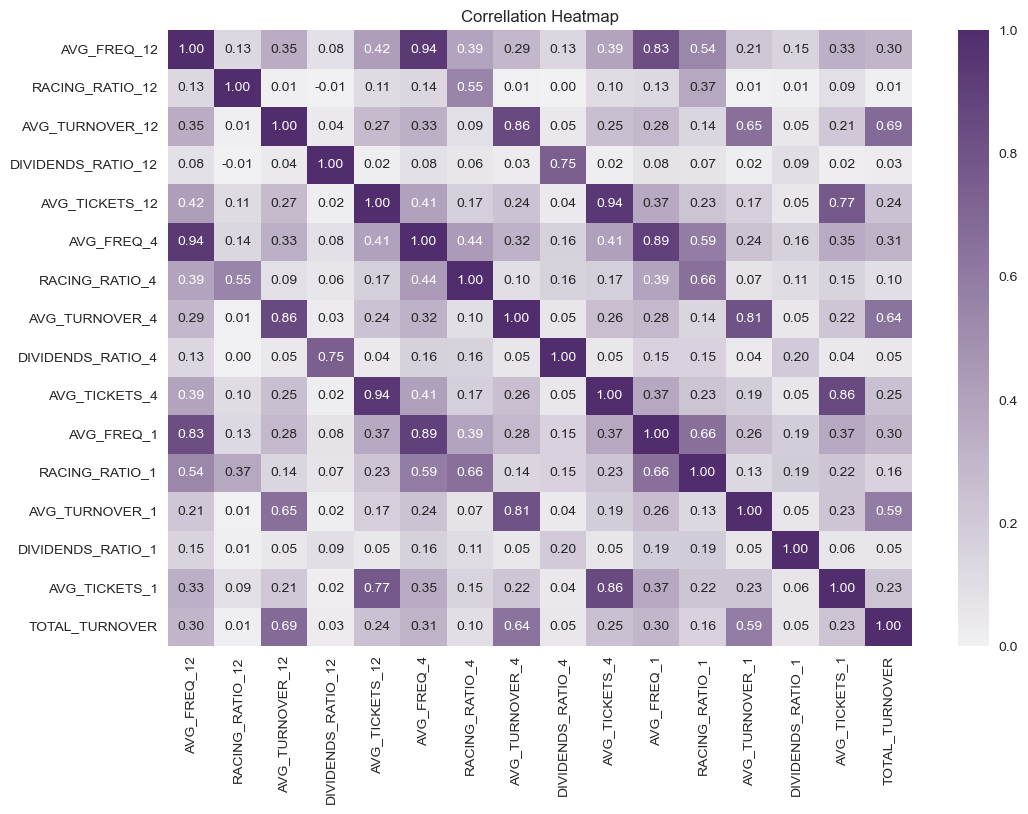

In [57]:
df_corr = train_1.corr()

plt.figure(figsize=(12,8))

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(df_corr, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")
plt.title("Correllation Heatmap")

plt.plot();

In [76]:
len(train_1.columns)

16

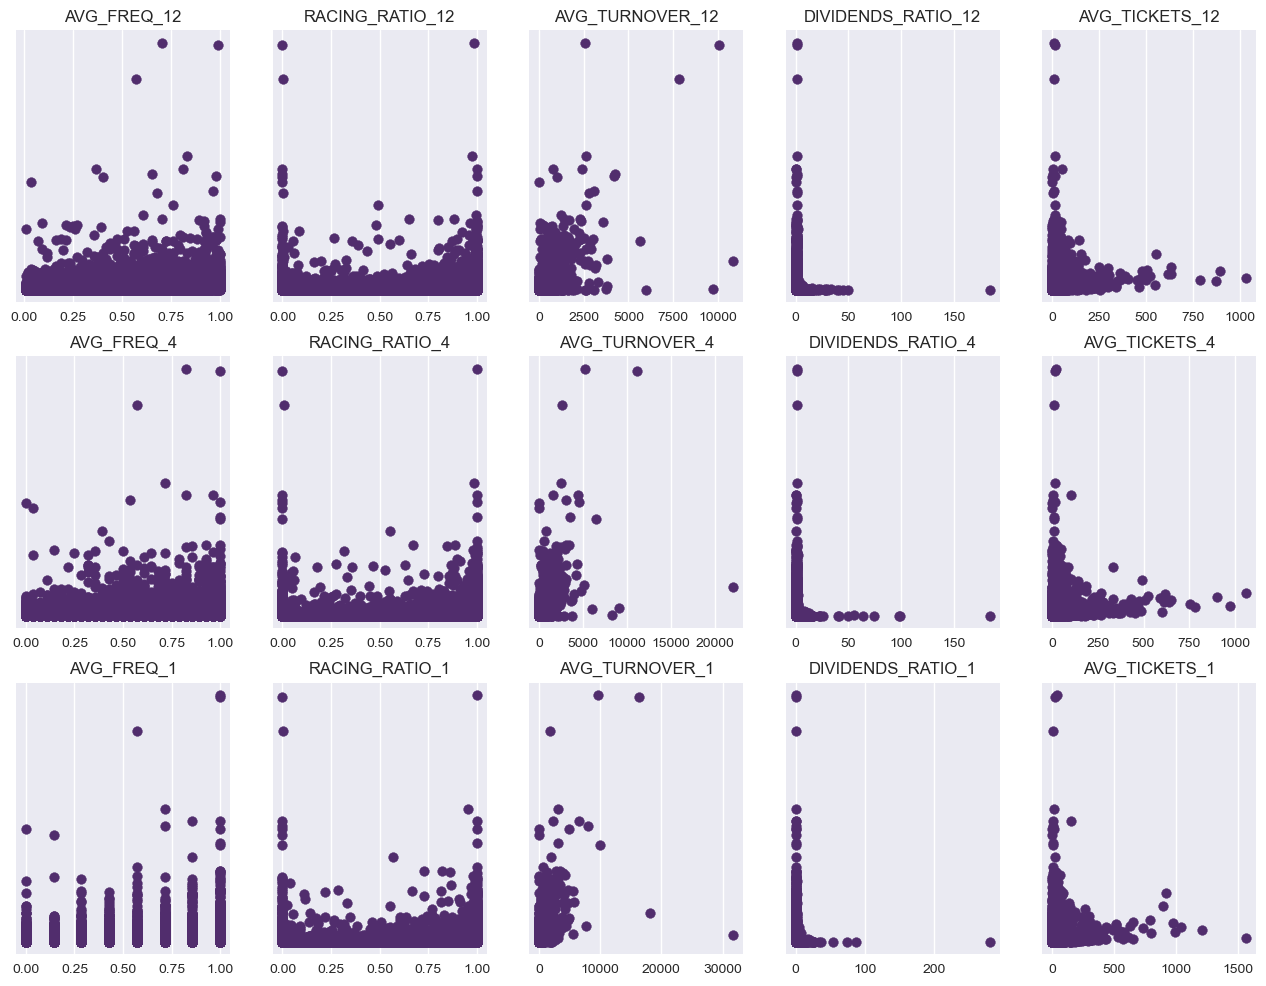

In [77]:
fig, axes = plt.subplots(3,5,figsize=(16,12))

for i in range(3):
    for j in range(5):
        axes[i,j].scatter(train_1.iloc[:,i*5 + j], train.iloc[:,-1])
        axes[i,j].set_title(train_1.columns[i*5+ j]) 
        axes[i,j].set_yticks([])

In [59]:
X = train_1.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_1['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     4476.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:23:24   Log-Likelihood:            -3.8136e+05
No. Observations:               62116   AIC:                         7.627e+05
Df Residuals:                   62100   BIC:                         7.629e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1687      1.407      2.963      0.003       1.411       6.927
x1           -53.5505      5.352    -10.006      0.000     -64.040     -43.061
x2            -2.1859      1.787     -1.223      0.221      -5.689       1.317
x3             0.5782      0.006     97.772      0.000       0.567       0.590
x4            -0.4789      0.634     -0.755      0.450      -1.722       0.765
x5            -0.4582      0.074     -6.206      0.000      -0.603      -0.313
x6            68.7581      6.428     10.697      0.000      56.160      81.356
x7            -0.5982      1.575     -0.380      0.704      -3.684       2.488
x8            -0.0820      0.006    -12.695      0.000      -0.095      -0.069
x9             0.3782      0.546      0.693      0.488      -0.691       1.447
x10            0.7475      0.084      8.874      0.000       0.582       0.913
x11           31.0227      3.896      7.962      0.000      23.386      38.660
x12           -4.8001      1.530     -3.138      0.002      -7.798      -1.802
x13            0.1828      0.003     53.974      0.000       0.176       0.189
x14            0.2183      0.319      0.683      0.494      -0.408       0.844
x15            0.0295      0.040      0.731      0.465      -0.050       0.109
==============================================================================
Omnibus:                    88246.710   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3783229951.013
Skew:                           6.824   Prob(JB):                         0.00
Kurtosis:                    1211.948   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

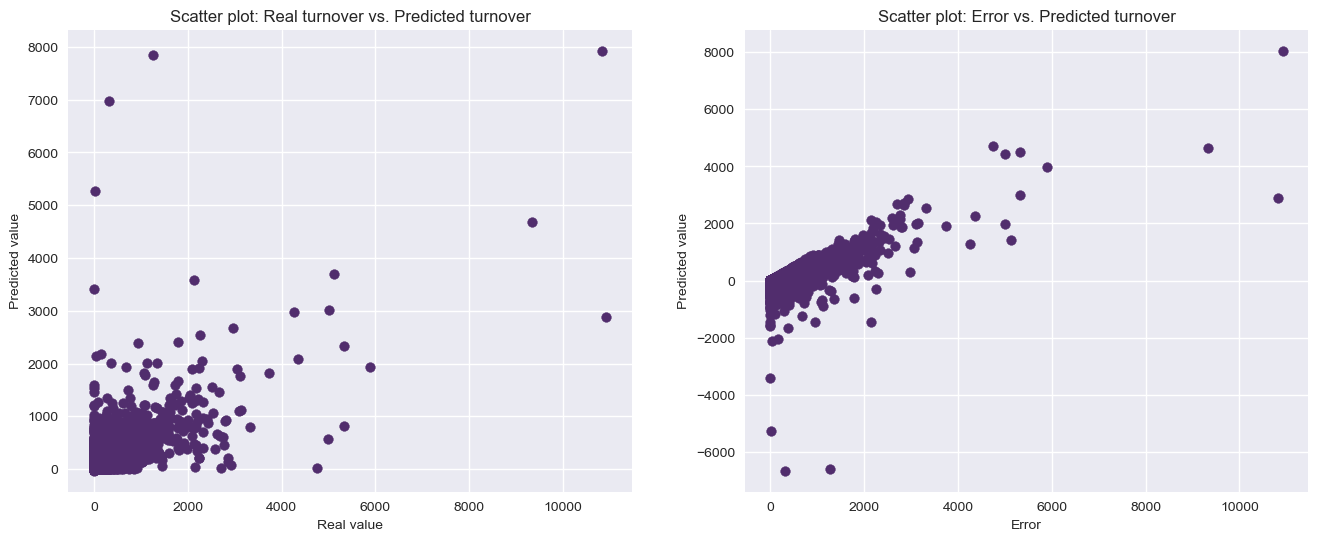

In [60]:
y_pred = results.predict(X)
e =y.flatten() -y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(y, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(y, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [80]:
sum(e**2)/62116

12595.33988046882

---------------------------

In [81]:
train_2 = train.drop(['TENURE_IN_DAYS_1', 'TENURE_IN_DAYS_4','TENURE_IN_DAYS_12',
    'RACING_RATIO_12', 'DIVIDENDS_RATIO_12', 'RACING_RATIO_4', 'DIVIDENDS_RATIO_4', 'DIVIDENDS_RATIO_1', 'AVG_TICKETS_1'],axis=1)

In [82]:
X = train_2.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_2['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     7459.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:44:43   Log-Likelihood:            -3.8136e+05
No. Observations:               62116   AIC:                         7.627e+05
Df Residuals:                   62106   BIC:                         7.628e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2050      0.709      3.108      0.002       0.814       3.595
x1           -53.5995      5.321    -10.074      0.000     -64.028     -43.171
x2             0.5785      0.006     97.885      0.000       0.567       0.590
x3            -0.4729      0.072     -6.535      0.000      -0.615      -0.331
x4            67.6957      6.206     10.907      0.000      55.531      79.860
x5            -0.0825      0.006    -12.874      0.000      -0.095      -0.070
x6             0.7861      0.067     11.788      0.000       0.655       0.917
x7            32.8169      3.695      8.883      0.000      25.576      40.058
x8            -5.7656      1.225     -4.705      0.000      -8.167      -3.364
x9             0.1832      0.003     54.978      0.000       0.177       0.190
==============================================================================
Omnibus:                    88207.254   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3784784176.191
Skew:                           6.817   Prob(JB):                         0.00
Kurtosis:                    1212.196   Cond. No.                     5.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

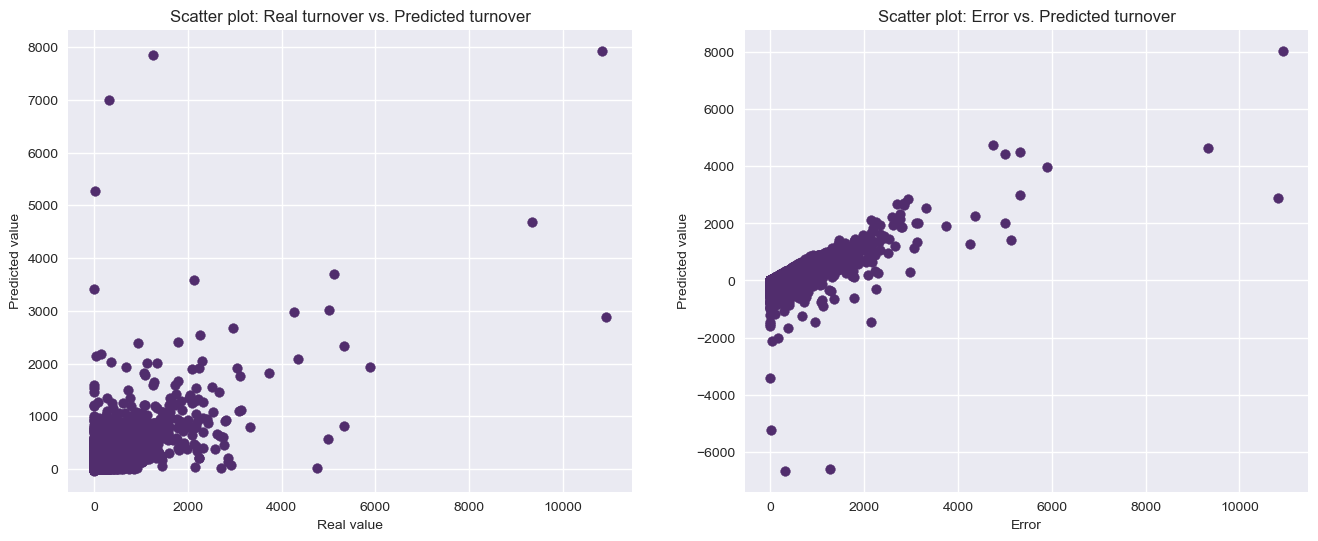

In [83]:
y_pred = results.predict(X)
e =y.flatten() -y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(y, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(y, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [85]:
sum(e**2)/62116

12595.33988046882

--------------------------

In [116]:
train_3 = train[[
    'AVG_TURNOVER_1',
    'AVG_TURNOVER_4',
    'AVG_TURNOVER_12',
    'AVG_TICKETS_12',
    'AVG_TICKETS_4',
    'AVG_TICKETS_1',
    'TOTAL_TURNOVER'
]]
train_3 = np.log(train_3+1)

In [117]:
X = train_3.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_3['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 2.820e+04
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:00:31   Log-Likelihood:                -84569.
No. Observations:               62116   AIC:                         1.692e+05
Df Residuals:                   62109   BIC:                         1.692e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0647      0.007      9.799      0.000       0.052       0.078
x1             0.3080      0.007     44.521      0.000       0.294       0.322
x2             0.3002      0.009     32.499      0.000       0.282       0.318
x3             0.2802      0.008     37.199      0.000       0.265       0.295
x4             0.1642      0.016     10.298      0.000       0.133       0.195
x5             0.0375      0.020      1.865      0.062      -0.002       0.077
x6            -0.1149      0.014     -8.324      0.000      -0.142      -0.088
==============================================================================
Omnibus:                     5655.630   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40920.373
Skew:                          -0.027   Prob(JB):                         0.00
Kurtosis:                       6.976   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

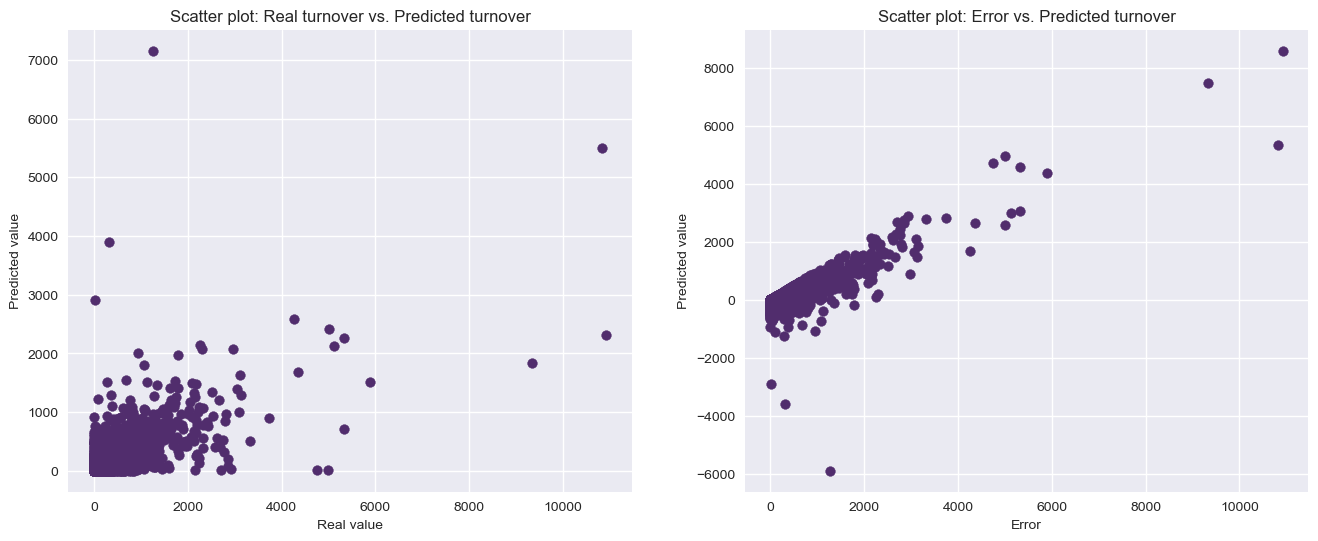

In [128]:
y_pred = np.exp(results.predict(X))-1
e = train['TOTAL_TURNOVER'].values - y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(train['TOTAL_TURNOVER'].values, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(train['TOTAL_TURNOVER'].values, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [129]:
sum(e**2)/62116

12989.15556105358

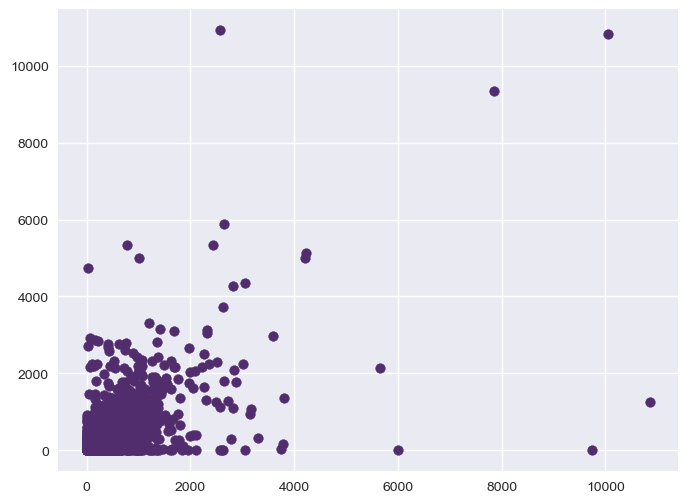

In [157]:
plt.figure(figsize=(8,6))
plt.scatter(train['AVG_TURNOVER_12'],train['TOTAL_TURNOVER'])

# Regression tree

In [86]:
X = train.drop(['TOTAL_TURNOVER'], axis=1)
y = train['TOTAL_TURNOVER']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [88]:
for i in range(3,26,1):
    tree_reg = DecisionTreeRegressor(max_depth=i
#                                     ,min_weight_fraction_leaf=0.05
                                    )
    tree_reg.fit(X_train,y_train)
    
    y_pred = tree_reg.predict(X_test)
    e = y_test - y_pred
    mse = sum(e**2)/15529
    
    print(str(i) + " : ", mse)

3 :  13560.725256689388
4 :  13852.840641464592
5 :  18041.335942549777
6 :  18149.642409348642
7 :  22135.12000385022
8 :  24985.08265278605
9 :  26570.576838274814
10 :  23996.939205998453
11 :  22549.946664431223
12 :  23515.997810215486
13 :  24875.93441593768
14 :  23485.85970964839
15 :  29251.643732338347
16 :  29929.130284253624
17 :  27922.377349295202
18 :  24799.527269118193
19 :  29699.997414216945
20 :  29195.950080201477
21 :  28269.85475169902
22 :  27367.469788277405
23 :  24317.017442663157
24 :  29633.760274666693
25 :  27804.79918266468


In [89]:
for i in range(3,26):
    tree_reg = DecisionTreeRegressor(max_depth=i, min_weight_fraction_leaf=0.05)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(tree_reg, X, y, cv=kfold, scoring = 'neg_mean_squared_error')
    
    print(str(i) + " : ", scores.mean())

3 :  -18342.748006012793
4 :  -18312.527999606187
5 :  -18303.7259097088
6 :  -18302.367465021693
7 :  -18302.11408290399
8 :  -18302.044173738403
9 :  -18302.04443843617
10 :  -18302.043211292155
11 :  -18302.043211292155
12 :  -18302.043211292155
13 :  -18302.04321129216
14 :  -18302.04321129215
15 :  -18302.04321129216
16 :  -18302.04321129215
17 :  -18302.04321129215
18 :  -18302.043211292155
19 :  -18302.043211292155
20 :  -18302.04321129216
21 :  -18302.04321129216
22 :  -18302.043211292155
23 :  -18302.043211292155
24 :  -18302.043211292155
25 :  -18302.043211292155


# Random forest

In [150]:
X = train.drop(['TOTAL_TURNOVER'], axis=1)
y = train['TOTAL_TURNOVER']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [155]:
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [156]:
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

10981.072981338963

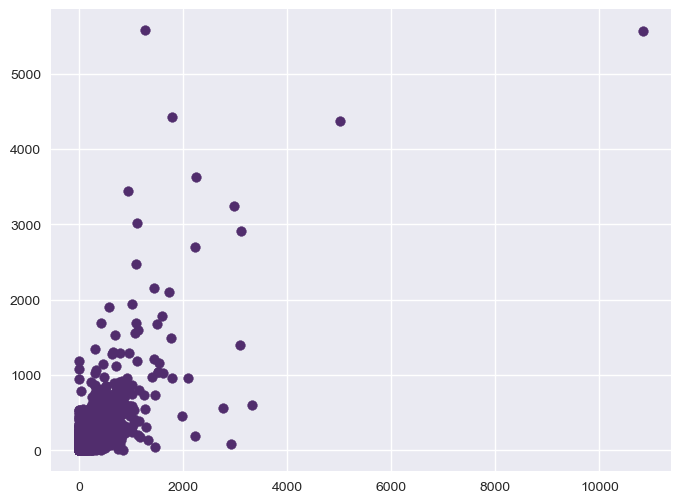

In [158]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred)